Prepare

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [8]:
# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))
min_class_size

6313

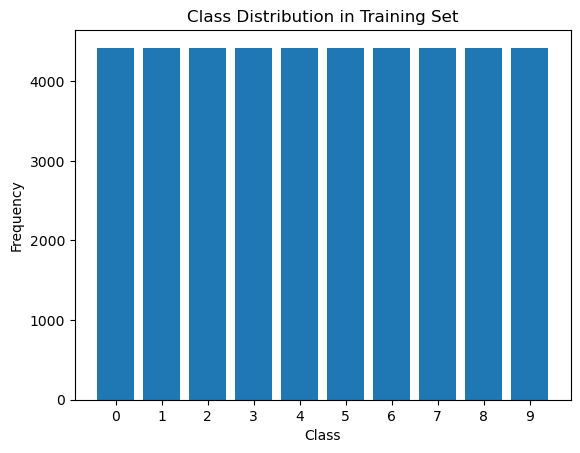

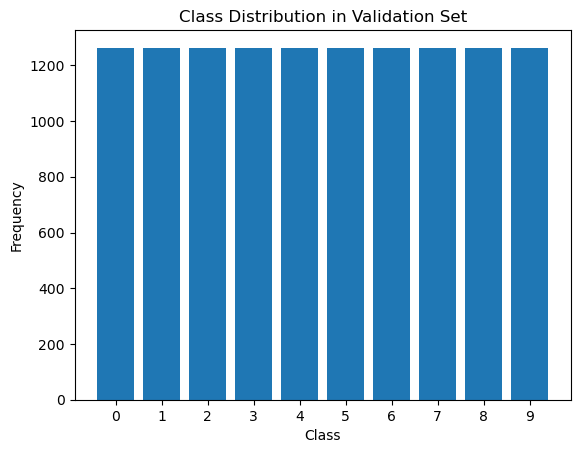

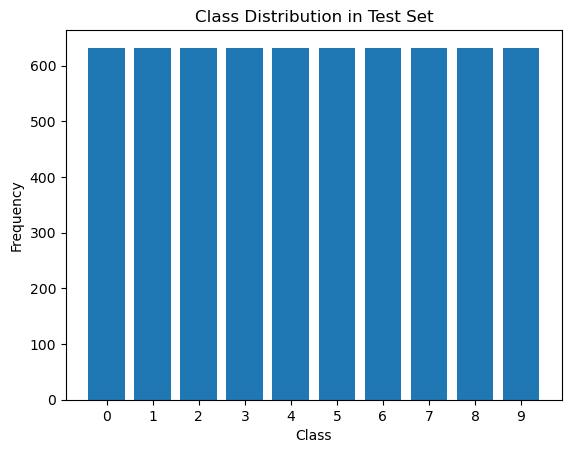

In [9]:
# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)
for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')

Prepare EMNIST to gauge generalisation

In [11]:
from emnist import extract_training_samples, extract_test_samples

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
# emnist_labels = to_categorical(emnist_labels, 10)
# emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000,))

Shape of one-hot encoded labels: (10000, 10)


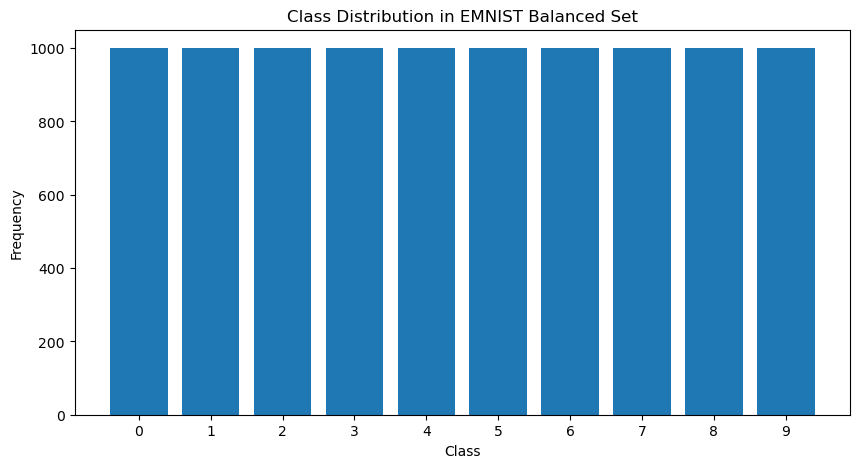

In [12]:
# Assuming emnist_test_labels is already loaded and is a flat array of labels (not one-hot encoded)
unique_classes = np.unique(emnist_test_labels)
sample_per_class = 1000
balanced_indices = []

for cls in unique_classes:
    cls_indices = np.where(emnist_test_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    balanced_indices.extend(cls_sample_indices)

# Now, extract the images and labels using the indices
emnist_x_balanced = emnist_test_images[balanced_indices]
emnist_y_balanced = emnist_test_labels[balanced_indices]

# Normalize, reshape, and convert labels to one-hot encoding as necessary
emnist_x_balanced = emnist_x_balanced.astype('float32') / 255
emnist_x_balanced = emnist_x_balanced.reshape(-1, 28, 28, 1)
emnist_y_balanced_one_hot = to_categorical(emnist_y_balanced, 10)

def plot_class_distribution(labels, dataset_name):
    class_counts = np.sum(labels, axis=0)  # This should result in a shape of (10,)
    plt.figure(figsize=(10, 5))
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Make sure emnist_y_balanced_one_hot is correctly shaped as (10000, 10)
print("Shape of one-hot encoded labels:", emnist_y_balanced_one_hot.shape)
plot_class_distribution(emnist_y_balanced_one_hot, 'EMNIST Balanced')

Train the model

In [22]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

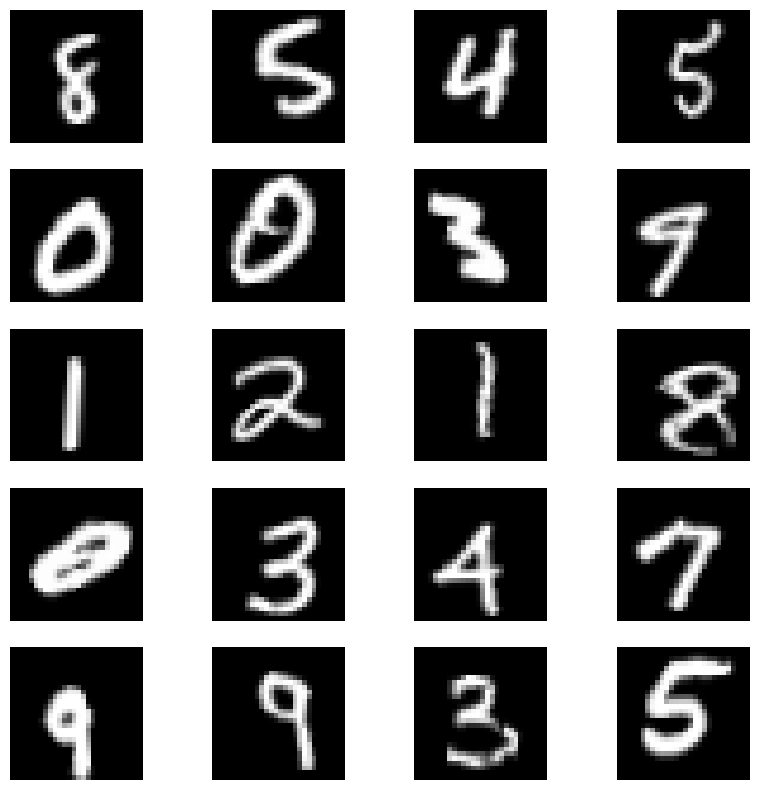

In [18]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Fit the data augmentation
datagen.fit(x_train_cnn)

# # Use the data generator to augment the training data
# cnn_model.fit(datagen.flow(x_train_cnn, y_train, batch_size=64), epochs=10, validation_data=(x_val_cnn, y_val))

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_cnn, y_train, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [24]:
# Define the CNN model
cnn_model_1 = Sequential([

    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),           # Standardise inputs to next layer, improving the stability and speed of the training process
    MaxPooling2D((2, 2)),           # Reduces the spatial dimensions of the output from the previous layer, reducing the number of parameters and computation in the network
    Dropout(0.25),                  # Mitigates overfitting for each layer

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Flattening the convolutions
    Flatten(),

    # Dense Layers
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
cnn_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_6 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 11, 11, 64)      

In [26]:
# Use the data generator to augment the training data
cnn_history_1 = cnn_model_1.fit(datagen.flow(x_train_cnn, y_train, batch_size=32),
                            epochs=30,
                            validation_data=(x_val_cnn, y_val))

Epoch 1/30


2024-02-17 18:05:15.378636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-17 18:05:15.383777: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1381/1381 [==============================] - 16s 12ms/step - loss: 1.0240 - accuracy: 0.6818 - val_loss: 0.3031 - val_accuracy: 0.9043
Epoch 2/30
1381/1381 [==============================] - 16s 11ms/step - loss: 0.4181 - accuracy: 0.8679 - val_loss: 0.1240 - val_accuracy: 0.9594
Epoch 3/30
1381/1381 [==============================] - 16s 11ms/step - loss: 0.3331 - accuracy: 0.8966 - val_loss: 0.1276 - val_accuracy: 0.9623
Epoch 4/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2891 - accuracy: 0.9112 - val_loss: 0.1247 - val_accuracy: 0.9605
Epoch 5/30
1381/1381 [==============================] - 19s 14ms/step - loss: 0.2628 - accuracy: 0.9188 - val_loss: 0.1454 - val_accuracy: 0.9523
Epoch 6/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2408 - accuracy: 0.9266 - val_loss: 0.2256 - val_accuracy: 0.9262
Epoch 7/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2292 - accuracy: 0.9314 - val_loss: 0.0760 - val_accura

KeyboardInterrupt: 

Evaluate on MNIST

[0.6818, 0.8679, 0.8966, 0.9112, 0.9188, 0.9266, 0.9314, 0.9355, 0.9372, 0.9394, 0.9412, 0.9427, 0.9443, 0.9455, 0.9428, 0.9456, 0.9465, 0.9468, 0.9483]


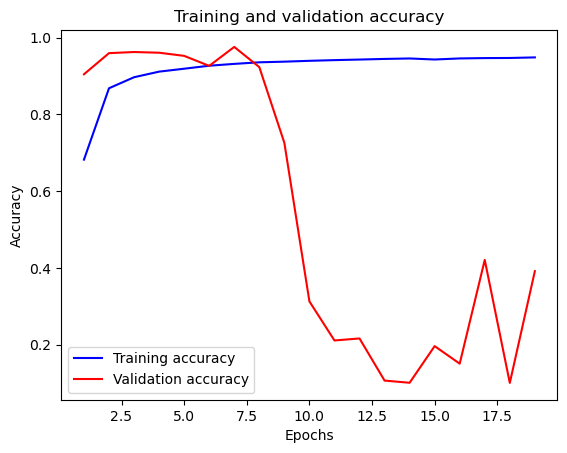

In [32]:
import matplotlib.pyplot as plt

# Provided data
data = """
1381/1381 [==============================] - 16s 12ms/step - loss: 1.0240 - accuracy: 0.6818 - val_loss: 0.3031 - val_accuracy: 0.9043
Epoch 2/30
1381/1381 [==============================] - 16s 11ms/step - loss: 0.4181 - accuracy: 0.8679 - val_loss: 0.1240 - val_accuracy: 0.9594
Epoch 3/30
1381/1381 [==============================] - 16s 11ms/step - loss: 0.3331 - accuracy: 0.8966 - val_loss: 0.1276 - val_accuracy: 0.9623
Epoch 4/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2891 - accuracy: 0.9112 - val_loss: 0.1247 - val_accuracy: 0.9605
Epoch 5/30
1381/1381 [==============================] - 19s 14ms/step - loss: 0.2628 - accuracy: 0.9188 - val_loss: 0.1454 - val_accuracy: 0.9523
Epoch 6/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2408 - accuracy: 0.9266 - val_loss: 0.2256 - val_accuracy: 0.9262
Epoch 7/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2292 - accuracy: 0.9314 - val_loss: 0.0760 - val_accuracy: 0.9756
Epoch 8/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2146 - accuracy: 0.9355 - val_loss: 0.2384 - val_accuracy: 0.9230
Epoch 9/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.2047 - accuracy: 0.9372 - val_loss: 1.0820 - val_accuracy: 0.7257
Epoch 10/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1998 - accuracy: 0.9394 - val_loss: 4.0555 - val_accuracy: 0.3125
Epoch 11/30
1381/1381 [==============================] - 17s 12ms/step - loss: 0.1926 - accuracy: 0.9412 - val_loss: 6.9502 - val_accuracy: 0.2106
Epoch 12/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1853 - accuracy: 0.9427 - val_loss: 5.3545 - val_accuracy: 0.2159
Epoch 13/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1836 - accuracy: 0.9443 - val_loss: 10.5218 - val_accuracy: 0.1061
Epoch 14/30
1381/1381 [==============================] - 16s 11ms/step - loss: 0.1810 - accuracy: 0.9455 - val_loss: 6.6832 - val_accuracy: 0.1004
Epoch 15/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1894 - accuracy: 0.9428 - val_loss: 4.5654 - val_accuracy: 0.1959
Epoch 16/30
1381/1381 [==============================] - 18s 13ms/step - loss: 0.1781 - accuracy: 0.9456 - val_loss: 4.2785 - val_accuracy: 0.1502
Epoch 17/30
1381/1381 [==============================] - 17s 12ms/step - loss: 0.1770 - accuracy: 0.9465 - val_loss: 2.7899 - val_accuracy: 0.4205
Epoch 18/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1744 - accuracy: 0.9468 - val_loss: 9.0700 - val_accuracy: 0.1000
Epoch 19/30
1381/1381 [==============================] - 16s 12ms/step - loss: 0.1697 - accuracy: 0.9483 - val_loss: 2.9222 - val_accuracy: 0.3913
"""

# Parse the data to extract accuracy and val_accuracy values
accuracy_values = []
val_accuracy_values = [0.9043, 0.9594, 0.9623, 0.9605, 0.9523, 0.9262, 0.9756, 0.9230, 0.7257, 0.3125, 0.2106, 0.2159, 0.1061, 0.1004, 0.1959, 0.1502, 0.4205, 0.1000, 0.3913]

lines = data.strip().split('\n')
for line in lines:
    parts = line.split()
    if len(parts) >= 10:
        if parts[9] == 'accuracy:':
            accuracy_values.append(float(parts[10]))
        elif parts[9] == 'val_accuracy:':
            val_accuracy_values.append(float(parts[10]))

print(accuracy_values)

# Plotting the accuracy values
epochs = range(1, len(accuracy_values) + 1)

plt.plot(epochs, accuracy_values, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation accuracy')  # Plotting validation accuracy
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
from sklearn.metrics import confusion_matrix, classification_report

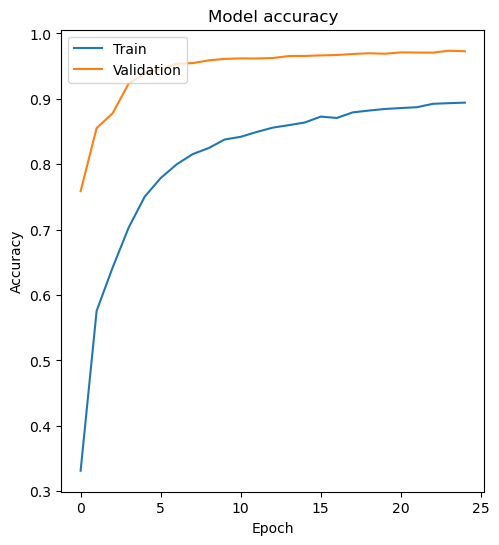

In [48]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_1.history['accuracy'])
plt.plot(cnn_history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [54]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model_1.predict(x_val_cnn)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

395/395 [==============================] - 1s 2ms/step
Precision:  0.972881410095359
Recall:  0.9728338349437669
F1 Score:  0.9728028735823184
Confusion Matrix:
 [[1246    0    0    1    0    1    8    2    3    1]
 [   1 1245    8    3    2    0    0    0    3    0]
 [   1    3 1232    7    3    1    0    6    9    1]
 [   3    0   13 1222    0   11    0    5    5    3]
 [   1    0    2    0 1234    0    5    2    0   19]
 [   1    1    1   10    1 1235    8    0    1    5]
 [   4    1    0    0    1    5 1250    0    2    0]
 [   2    3   15    8    1    1    0 1224    2    7]
 [   3    0    3    8    8   21   17    4 1193    6]
 [   7    1    0   13   19    3    1   15    1 1202]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1262
           1       0.99      0.99      0.99      1262
           2       0.97      0.98      0.97      1263
           3       0.96      0.97      0.96      1262
           4

Evaluate on EMNIST

In [59]:
# Evaluate on MNIST Validation Set
y_emnist_pred_probs = cnn_model_1.predict(emnist_x_balanced)
emnist_y_pred = np.argmax(y_emnist_pred_probs, axis=1)
emnist_y_true = emnist_y_balanced

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
recall = recall_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
f1 = f1_score(emnist_y_true, emnist_y_pred, average='weighted', zero_division=0)
conf_mat = confusion_matrix(emnist_y_true, emnist_y_pred)
report = classification_report(emnist_y_true, emnist_y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

313/313 [==============================] - 1s 2ms/step
Precision:  0.9608986655955285
Recall:  0.9605
F1 Score:  0.9602142306032729
Confusion Matrix:
 [[991   0   3   0   0   1   3   0   1   1]
 [  0 983   5   0   0   0   4   3   5   0]
 [  6   1 966   8   4   0   1   0  14   0]
 [  1   0  10 974   0   9   0   1   4   1]
 [  2   3   2   0 945   0  13   4   7  24]
 [  8   0   0   5   0 981   3   0   3   0]
 [  9   0   1   0   1   2 987   0   0   0]
 [  0   3  15   6   1   0   0 966   7   2]
 [  9   2   3  11   0  11   3   2 958   1]
 [  2   0   1  14  17   6   2  63  41 854]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1000
           1       0.99      0.98      0.99      1000
           2       0.96      0.97      0.96      1000
           3       0.96      0.97      0.97      1000
           4       0.98      0.94      0.96      1000
           5       0.97      0.98      0.98      1000
           6   

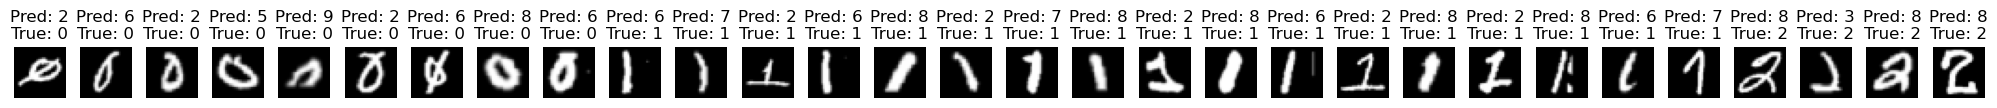

In [62]:
# Identify misclassified images
misclassified_indices = np.where(emnist_y_pred != emnist_y_true)[0]
misclassified_images = emnist_x_balanced[misclassified_indices]
misclassified_predictions = emnist_y_pred[misclassified_indices]
true_labels_misclassified = emnist_y_true[misclassified_indices]

# Plot a sample of misclassified images
num_images_to_show = 30
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        ax.imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {misclassified_predictions[i]}\nTrue: {true_labels_misclassified[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()